**Importing libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import os


**Data Preprocessing**

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 32




In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\fastf\Downloads\eye disease\dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4217 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

In [5]:
len(dataset)

132

**Visualization**

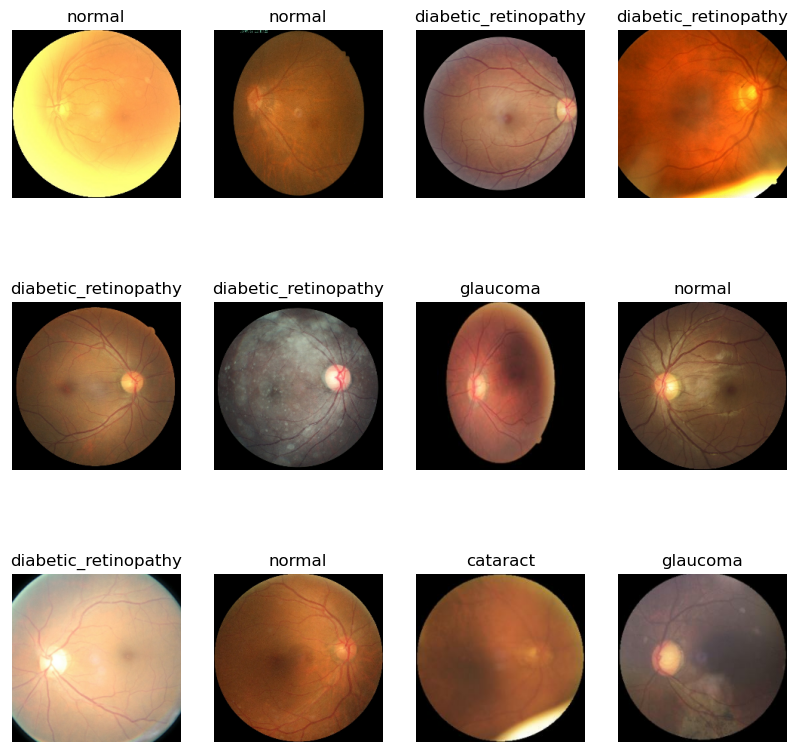

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

**Dataset Split Criteria 
80% ==> training
10% ==> validation
10% ==> testing**

In [7]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size  = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    ds_size = tf.data.experimental.cardinality(ds).numpy()

    train_size = int(train_split * ds_size)
    val_size  = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds   = ds.skip(train_size).take(val_size)
    test_ds  = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds


In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
len(train_ds)

105

In [10]:
len(val_ds)

13

In [11]:
len(test_ds)

14

In [12]:
batch_size = 32
total_train_images = len(train_ds) * batch_size
print("Total training images:", total_train_images)


Total training images: 3360


**Rescaling and resizing**

In [13]:
import tensorflow as tf
from tensorflow.keras import layers

IMAGE_SIZE = 224  
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])


**Data Agumentation**

In [14]:
import tensorflow as tf
from tensorflow.keras import layers

IMAGE_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


**Build the CNN Model**

In [15]:
class_names = dataset.class_names
num_classes = len(class_names)


In [16]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False 


model = tf.keras.Sequential([
    
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


C:\Users\fastf\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [17]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,972 (9.87 MB)

 Trainable params: 329,476 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
history = model.fit(train_ds, validation_data=val_ds, epochs=25)



Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 75s 577ms/step - accuracy: 0.6550 - loss: 1.0053 - val_accuracy: 0.5865 - val_loss: 1.1881
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 547ms/step - accuracy: 0.7442 - loss: 0.6626 - val_accuracy: 0.6707 - val_loss: 0.8119
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 548ms/step - accuracy: 0.7910 - loss: 0.5570 - val_accuracy: 0.7260 - val_loss: 0.7865
Epoch 4/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 550ms/step - accuracy: 0.7923 - loss: 0.5400 - val_accuracy: 0.6995 - val_loss: 0.7942
Epoch 5/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 545ms/step - accuracy: 0.7858 - loss: 0.5490 - val_accuracy: 0.6803 - val_loss: 0.8349
Epoch 6/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 549ms/step - accuracy: 0.7874 - loss: 0.5213 - val_accuracy: 0.7500 - val_loss: 0.6661
Epoch 7/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 61s 538ms/step - accuracy: 0.7980 - loss: 0.5107 - val_accuracy: 0.7572 - val_loss: 0.6210
Epoch 8/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 62s 543ms/step - accuracy: 0.8167 - loss: 0

**Evaluate the Model**

In [20]:
loss, accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 418ms/step - accuracy: 0.7796 - loss: 0.6186
Validation Loss: 0.6137
Validation Accuracy: 0.7716


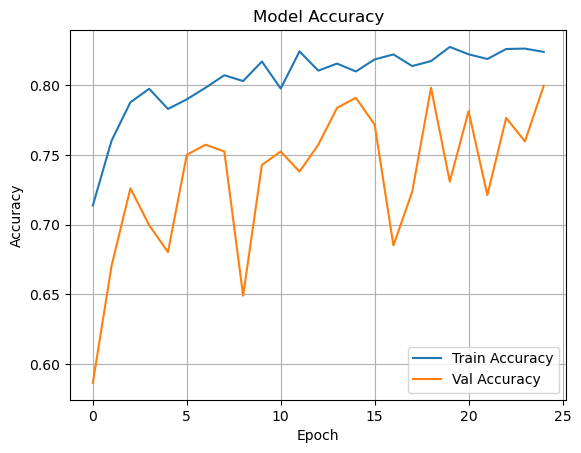

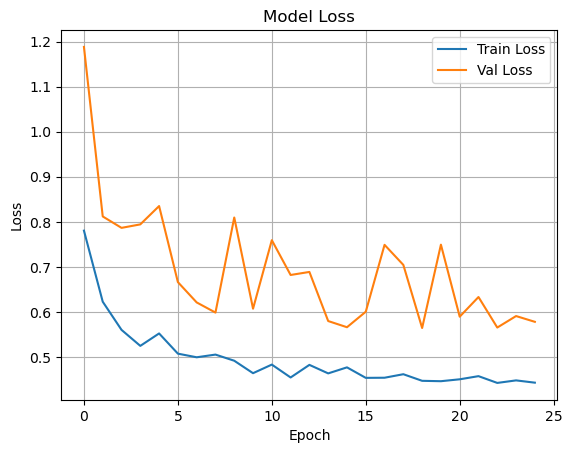

In [21]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


**Model prediction**

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


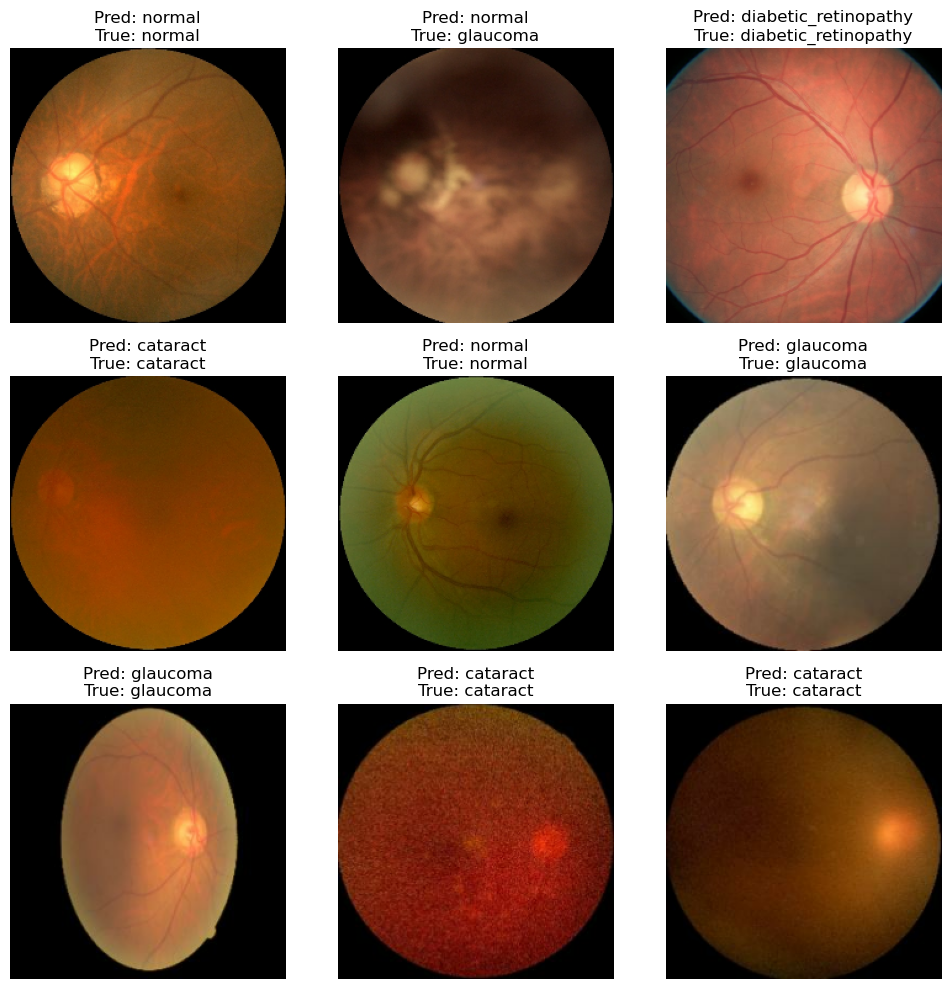

In [22]:
for image_batch, label_batch in test_ds.take(1):
    predictions = model.predict(image_batch)
    predicted_labels = tf.argmax(predictions, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image_np = image_batch[i].numpy()
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype("uint8")
        else:
            image_np = image_np.astype("uint8")
        plt.imshow(image_np)
        plt.title(f"Pred: {class_names[predicted_labels[i]]}\nTrue: {class_names[label_batch[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()




**Evaluate with confusion matrix**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 547ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step


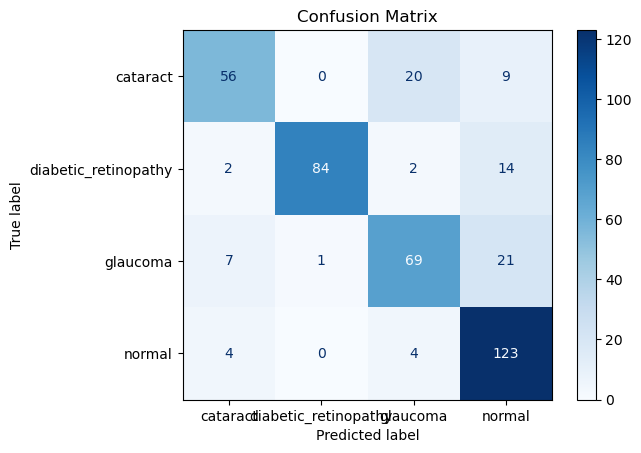

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(preds, axis=1).numpy())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [24]:
model.save("eye_disease_model.h5")


In [25]:
import os
print(os.listdir())  


['.ipynb_checkpoints', 'eye disease predictive model and diagnosis.ipynb', 'eye_disease_model.h5']


**Diagnosis of Disease**

In [26]:
img_height = 224
img_width = 224
diagnosis_dict = {
    "cataract": "Cataract is a clouding of the eye’s lens, leading to blurred vision. It may require surgery if severe.",
    "diabetic_retinopathy": "Diabetic Retinopathy is caused by damage to the blood vessels in the retina due to diabetes. Regular checkups and blood sugar control are essential.",
    "glaucoma": "Glaucoma causes increased pressure in the eye, damaging the optic nerve. Early treatment can help prevent vision loss.",
    "normal": "The eye appears healthy and no signs of disease are detected. Continue routine eye checkups."
}


In [27]:
def predict_image_with_diagnosis(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  

    prediction = model.predict(img_array)
    predicted_index = tf.argmax(prediction[0]).numpy()
    predicted_class = class_names[predicted_index]
    confidence = tf.reduce_max(tf.nn.softmax(prediction[0])).numpy()
    
    diagnosis = diagnosis_dict[predicted_class]
    
    return predicted_class, confidence, diagnosis


In [28]:
import os

folder_path = r"C:\Users\fastf\Downloads\eye disease\dataset\normal"
files = os.listdir(folder_path)
print("Files in folder:", files)


Files in folder: ['1034_left.jpg', '1034_right.jpg', '1060_left.jpg', '1060_right.jpg', '1253_left.jpg', '1253_right.jpg', '2329_left.jpg', '2329_right.jpg', '2331_left.jpg', '2331_right.jpg', '2332_left.jpg', '2332_right.jpg', '2334_left.jpg', '2334_right.jpg', '2335_left.jpg', '2335_right.jpg', '2341_left.jpg', '2341_right.jpg', '2345_left.jpg', '2345_right.jpg', '2346_left.jpg', '2346_right.jpg', '2349_left.jpg', '2349_right.jpg', '2351_left.jpg', '2351_right.jpg', '2353_left.jpg', '2353_right.jpg', '2354_left.jpg', '2354_right.jpg', '2355_left.jpg', '2355_right.jpg', '2356_left.jpg', '2356_right.jpg', '2359_left.jpg', '2359_right.jpg', '2362_left.jpg', '2362_right.jpg', '2363_left.jpg', '2363_right.jpg', '2365_left.jpg', '2365_right.jpg', '2366_left.jpg', '2366_right.jpg', '2367_left.jpg', '2367_right.jpg', '2368_left.jpg', '2368_right.jpg', '2369_left.jpg', '2369_right.jpg', '2371_left.jpg', '2371_right.jpg', '2372_left.jpg', '2372_right.jpg', '2377_left.jpg', '2378_left.jpg', '23

In [33]:
img_height = 224
img_width = 224
label, confidence, diagnosis = predict_image_with_diagnosis(
    r"C:\Users\fastf\Downloads\eye disease\dataset\normal\2813_left.jpg")
print(f"Prediction: {label}")
print(f"Diagnosis: {diagnosis}")
print("Please consult a doctor for a more accurate diagnosis.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Prediction: normal
Diagnosis: The eye appears healthy and no signs of disease are detected. Continue routine eye checkups.
Please consult a doctor for a more accurate diagnosis.
